In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog)
import scipy.io
import scipy.interpolate
from scipy import signal
from matplotlib import patches
from IPython.display import HTML

from mne.datasets import fetch_fsaverage
import os.path as op

from mne.minimum_norm import apply_inverse, make_inverse_operator

plt.rcParams['figure.figsize'] = [10, 5]

--------------

# USER INPUT: specify start time, end time, animation specific parameters

In [17]:
# ALLOW USER TO SPECIFY DATASET

# Specify electrode layout
electrode_layout = 'standard_1020' # toggle to switch to 'standard_1005' if needed, default to 'standard_1020'.

# Calculate starting/ending frames
start_hour = 0
start_minute = 2
start_second = 34
start_ms = 0

end_hour = 0
end_minute = 2
end_second = 34
end_ms = 200


# 2D topographic mapping specifications
time_between_frames = 0.005 # Time is in seconds
frame_rate = 12

-------

# Preparing/ Loading/ Creating Neccesary Data

## Data needed for all visualizations

### Load dataset + set EEG reference + set montage (electrode layout)

In [2]:
# Load raw dataset from .set file (also requires .fdt file to be in same locaiton)
raw = mne.io.read_raw_eeglab('../data/1122/fixica.set')

# Set EEG reference
raw = raw.set_eeg_reference(projection=True)

# Read and set the EEG electrode locations
montage = mne.channels.make_standard_montage(electrode_layout)
raw.set_montage(montage)

Reading /Users/mpin/Documents/MDS/capstone/simpl_eeg_capstone/data/1122/fixica.fdt


<ipython-input-2-2de7aa062170>:2: RuntimeWarning: Data file name in EEG.data (1122 fix ica.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw = mne.io.read_raw_eeglab('../data/1122/fixica.set')


Adding average EEG reference projection.
1 projection items deactivated


### Calculate frame to start/end animations on

In [18]:
# Set up events and use it to generate mock epoch and evoked data

user_event_frame = round((start_frame + end_frame)/2) # Pick frame in the middle of the two specified frames to build epoch around
user_event = ([[int(user_event_frame), 0, 1]]) # Format event to make mock epoch
user_event = np.array(user_event)

min_time = 0 - duration/2 # time to start from before epoch, should line up with user specified start time
max_time = 0 + duration/2 # time to stop from after epoch time, should line up with user specified end time

 # Doesn't seem to like this version which starts the epoch at 0 rather than in the middle, might be better if it's possible
# user_event_frame = start_frame 
# user_event = ([[int(user_event_frame), 0, 1]])
# user_event = np.array(user_event)
# min_time = 0
# max_time = duration

-----------

## Data needed for 2D topographic map, 3D brain map

### Create mock epoch and evoked data from timestamp - IS TIMESTAMP SPECIFIC

In [19]:
%%time 
event_dict = {'user_specified_time': 1} # Create single mock event, needed to make epoch 

user_epoch = mne.Epochs(raw,
                        user_event,
                        tmin = min_time,
                        tmax = max_time,
                        event_id = event_dict,
                        preload=True)

user_evoked = user_epoch['user_specified_time'].average()

Not setting metadata
Not setting metadata
1 matching events found
Setting baseline interval to [-0.10009765625, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 1 events and 411 original time points ...
0 bad epochs dropped


-------

## Data needed for 3D brain map

### Loading stock MRI data (a brain to map to) - NOT TIMESTAMP SPECIFIC, NOT DATASET SPECIFIC, NEEDED FOR: "Creating forward"

In [20]:
%%time\

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# Used to download/load example MRI brain model
# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in /Users/mpin/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage


### Creating forward (3D spatial data of brain + mapping) - NOT TIMESTAMP SPECIFIC, DATASET SPECIFIC

In [21]:
%%time

fwd = mne.make_forward_solution(raw.info,
                                trans=trans,
                                src=src,
                                bem=bem,
                                eeg=True,
                                mindist=5.0,
                                n_jobs=1)
print(fwd)

Source space          : /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /Users/mpin/opt/miniconda3/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  19 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM model 

### Creating Covariance + Inverse Operator (takes a long time) - NOT TIMESTAMP SPECIFIC, DATASET SPECIFIC¶

In [28]:
%%time

# NOT TIMESTAMP SPECIFIC
noise_cov = mne.compute_raw_covariance(
    raw,
    method=['empirical', 'shrunk'])

Using up to 29362 segments
Computing rank from data with rank=None
    Using tolerance 2.5e-10 (2.2e-16 eps * 19 dim * 6e+04  max singular value)
    Estimated rank (eeg): 18
    EEG: rank 18 computed from 19 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 19 -> 18
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using SHRUNK
Done.
Using cross-validation to select the best estimator.
Number of samples used : 12038420
log-likelihood on unseen data (descending order):
   shrunk: -27.966
   empirical: -164.172
selecting best estimator: shrunk
[done]
CPU times: user 9min 39s, sys: 2min 4s, total: 11min 44s
Wall time: 5min 18s


In [29]:
%%time
# make an MEG inverse operator
info = user_evoked.info
inverse_operator = make_inverse_operator(info,
                                         fwd,
                                         noise_cov,
                                         loose=0.2,
                                         depth=0.8)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 19 channels.
    19 out of 19 channels remain after picking
Selected 19 channels
Creating the depth weighting matrix...
    19 EEG channels
    limit = 20485/20484 = 2.732244
    scale = 37056.4 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.3e-14 (2.2e-16 eps * 19 dim * 3  max singular value)
    Estimated rank (eeg): 18
    EEG: rank 18 computed from 19 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of w

## Creating inverse solution (STC) - IS TIMESTAMP SPECIFIC

In [30]:
%%time

# Unsure about these values for the time being, currently using defaults from MNE documentation
snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# Compute inverse solution
stc = apply_inverse(user_evoked,
                    inverse_operator,
                    lambda2,
                    method,
                    pick_ori='normal')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 18 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "user_specified_time"...
    Picked 19 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  99.6% variance
    dSPM...
[done]
CPU times: user 476 ms, sys: 60.5 ms, total: 536 ms
Wall time: 218 ms


-------

# Visualization Functions

### Raw Voltage Values

Required data objects...
- timestamp data

Currently saves as...


-----

### 2D topographic map

Required data objects...
- raw
- timestamp data
- evoked

Currently saves as...
- HTML animation

Initializing animation...


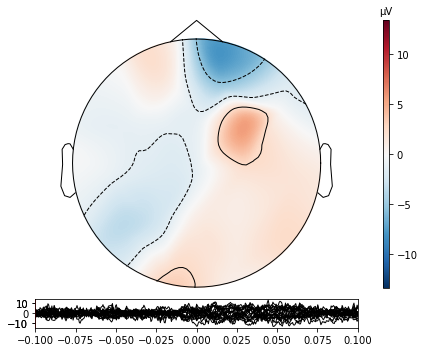

Initializing animation...
CPU times: user 48.9 s, sys: 2.21 s, total: 51.1 s
Wall time: 7.59 s


In [6]:
%%time
times = np.arange(min_time, max_time, time_between_frames) # start time, end time, time between frames NEEDS TO BE ADJUSTED STILL
fig, anim = user_evoked.animate_topomap(
    times=times,
    ch_type='eeg',
    frame_rate= frame_rate, # Frame rate in Hz
    butterfly = True, # Shows band at bottom, increases time to render
    time_unit='s', # Can be either ms or s
    blit=False, 
    sphere = 105, # Causes head to appear, see documentation, not sure what vlue should be here so 105 is placeholder
    extrapolate = 'head', # 'head' extrapolates points to head shape, 'local' to nearby points
    verbose = None); # No idea, something to do with debugging or something

# used to update axis values but causes problems with band
#anim.__dict__['_func'].keywords["params"]['times'] = np.array([0]) 
#anim.__dict__['_func'].keywords["params"]['all_times'] = np.array([0, duration/2, duration]) 

HTML(anim.to_jshtml())

-----

### 3D Topographic Skull Map

Required data objects...
- timestamp data

Currently saves as...



--------

### 3D Topographic Brain Map

Required data objects...
- Inverse operator (stc)

Currently saves as...
- Gif

In [32]:
brain = stc.plot(views='lat',
                 hemi='split',
                 size=(800, 400),
                 subject= None,
                 initial_time=0, #TIME CAN BE SPECIFIED WITH inital_time
                 time_viewer=False,
                 show_traces=False)

Using control points [17.25207658 20.19669676 40.6920968 ]


ViewInteractiveWidget(height=400, layout=Layout(height='auto'), width=800)

In [33]:
brain.save_movie('test_brain.gif',
                 time_dilation=20,
                 tmin= min_time,
                 tmax= max_time,
                 framerate=10,
                 interpolation='linear',
                 time_viewer=True)

------

### Connectivity visualization

Required data objects...
- timestamp data

Currently saves as...